### CS 178: Machine Learning &amp; Data Mining

# Final Project: CNN on Facial Expressions


In [1]:
# Common libs
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path

# Image processing
#import imageio
import cv2
#import skimage.transform
#from skimage.transform import rescale, resize, downscale_local_mean

# Charts
import matplotlib.pyplot as plt
# import seaborn as sns

# ML, statistics
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

# Tensorflow
#from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


In [2]:
image_directory = '../CS 178/cs178_facial_expressions/images/'

#### 1.2 Loading in legend 

In [3]:
# toy=True - development mode, small samples, limited training, fast run
# toy=False - full data, slow learning and run
toy= False

## downloading csv label file
## facial_df = facial dataframe
labels_url = "https://raw.githubusercontent.com/muxspace/facial_expressions/master/data/legend.csv"
facial_df = pd.read_csv(labels_url)
if toy:
    facial_df = facial_df.sample(500)

facial_df.head() #head returns first [.head(n)] n values

,user.id,image,emotion
0,628,facial-expressions_2868588k.jpg,anger
1,628,facial-expressions_2868585k.jpg,surprise
2,628,facial-expressions_2868584k.jpg,disgust
3,628,facial-expressions_2868582k.jpg,fear
4,dwdii,Aaron_Eckhart_0001.jpg,neutral


##### Preprocessing
Emotion labels are case-sensitive. So, need to preprocess and make them all the same.

In [4]:
facial_df['emotion'] = facial_df['emotion'].str.lower()
facial_labels = facial_df.emotion.unique()

##### Visualizing Labels

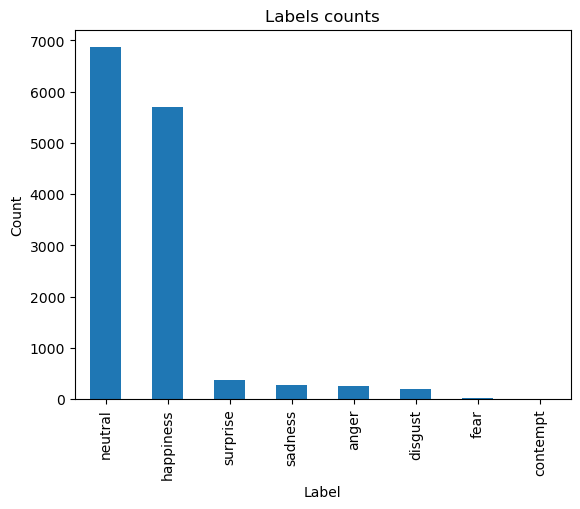

In [5]:
facial_df.emotion.value_counts().plot(kind='bar')
plt.title('Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

##### Visualizing Images (Basic)

../CS 178/cs178_facial_expressions/images/Dan_Dickau_0001.jpg
../CS 178/cs178_facial_expressions/images/Hillary_Clinton_0008.jpg
../CS 178/cs178_facial_expressions/images/Jayamadhuri_165.jpg
../CS 178/cs178_facial_expressions/images/John_Ashcroft_0028.jpg
../CS 178/cs178_facial_expressions/images/George_W_Bush_0148.jpg
../CS 178/cs178_facial_expressions/images/Jayamadhuri_43.jpg
../CS 178/cs178_facial_expressions/images/Dwarakish_9.jpg
../CS 178/cs178_facial_expressions/images/Milan_Kucan_0001.jpg


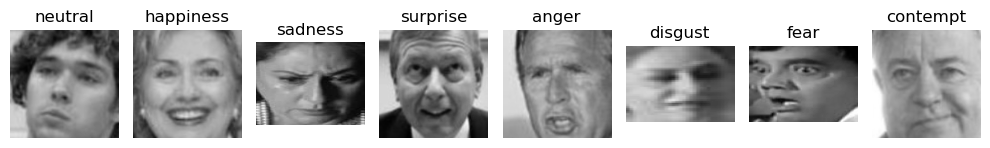

In [98]:
from io import BytesIO
from PIL import Image
import urllib



class ImageViewer:
    def read_img(self,id, folder="images"):
        """
        Read image by it's image name [id]
        """
        file = "../CS 178/cs178_facial_expressions/" + folder + "/" + id
        print(file)
        im=cv2.imread(str(file),  cv2.IMREAD_GRAYSCALE)
        return im

    def draw_sample_images(self):
        """
        Draws images for each label.
        labels: ['neutral' 'happiness' 'sadness' 'surprise' 'anger' 'disgust' 'fear' 'contempt']
        """
        ncols=8
        fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(10,7))
        
        labels=  ['neutral', 'happiness', 'sadness', 'surprise', 'anger' ,'disgust', 'fear', 'contempt']

        for col in range(0,ncols):
            try:
                sample = facial_df[facial_df['emotion']==labels[col]]['image'].sample(1).values
            except ValueError:
                continue
            
            im=self.read_img(sample[0])
            
            # [makes images appear the same size] Calculate the aspect ratio to maintain the original image proportions
            aspect_ratio = im.shape[1] / im.shape[0]
            ax[col].imshow(im, cmap="gray", vmin=0, vmax=255, extent=[0, 1, 0, 1 * aspect_ratio])
            

            ax[col].set_title(labels[col])
            ax[col].axis('off')  # Turn off axis labels
        fig.tight_layout()
        
testing = ImageViewer()
testing.draw_sample_images()



## Splitting Data

In [433]:
import imghdr
data_dir = image_directory
image_exts = ['jpeg','jpg', 'bmp', 'png']
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for image in os.listdir(data_dir): 
    image_path = os.path.join(data_dir, image)
  #  try: 
    img_type = imghdr.what(image_path)
    if img_type is None:
        print(f"{image_path} is not an image")
    elif img_type not in img_type_accepted_by_tf:
        print(f"{image_path} is a {img_type}, not accepted by TensorFlow")
        
    # except Exception as e: 
    #     print('Issue with image {}'.format(image_path))
    #     # os.remove(image_path)

# from pathlib import Path
# import imghdr

# data_dir = image_directory
# image_extensions = [".png", ".jpg"]  # add there all your images file extensions

# img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
# for filepath in Path(data_dir).rglob("*"):
#     if filepath.suffix.lower() in image_extensions:
#         img_type = imghdr.what(filepath)
#         if img_type is None:
#             print(f"{filepath} is not an image")
#         elif img_type not in img_type_accepted_by_tf:
#             print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

../CS 178/cs178_facial_expressions/images/facial-expressions_2868588k.jpg is a webp, not accepted by TensorFlow


In [434]:
os.remove('../CS 178/cs178_facial_expressions/images/facial-expressions_2868588k.jpg')

In [195]:
img_label_mapping = dict(zip(facial_df["image"], facial_df["emotion"]))


# Get a list of all image files in the directory
all_image_files = [file for file in os.listdir(image_directory) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
files_to_del = [f for f in all_image_files if f not in img_label_mapping.keys()]

for file_to_delete in files_to_delete:
    file_path = os.path.join(image_directory, file_to_delete)
    os.remove(file_path)  # Use os.unlink(file_path) if you prefer

In [6]:
all_image_files = [file for file in os.listdir(image_directory) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
labels = list()
label_num = {'anger': 0,
             'contempt': 1,
             'disgust': 2,
             'fear': 3,
             'happiness': 4,
             'neutral': 5,
             'sadness': 6,
             'surprise': 7}
label_list = ['anger','contempt','disgust','fear','happiness','neutral','sadness','surprise']

for i in all_image_files:
    emotion_label = facial_df.loc[facial_df['image'] == i, 'emotion'].values[0]
    labels.append(label_num[emotion_label])

In [7]:
#Create an image dataset with labels
img_data = tf.keras.utils.image_dataset_from_directory(   # creates data pipeline
    directory=image_directory,
    labels=labels,
    color_mode='grayscale',
    seed=1234)

Found 13681 files belonging to 8 classes.


In [331]:
data_iterator = img_data.as_numpy_iterator() 

In [336]:
batch = data_iterator.next() # len(batch) = 2 [images, labels]
print(batch[1])

[4 5 5 0 5 5 4 5 5 5 4 4 4 4 0 5 5 5 5 2 2 5 5 5 5 5 5 6 5 4 4 5]


In [337]:
scaled = batch[0] / 255

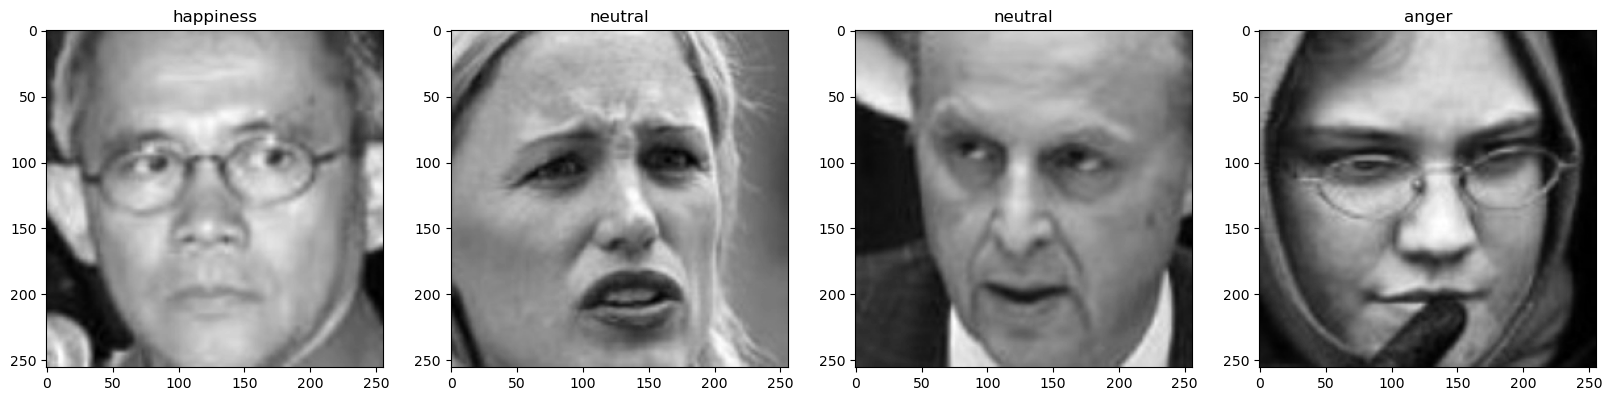

In [338]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int), cmap="gray")
    ax[idx].title.set_text(label_list[batch[1][idx]])

### Preprocess Data

#### Scale Data

In [8]:
img_data = img_data.map(lambda x,y: (x/255, y)) # makes our img values between 0 and 1 instead of 0 to 255

In [340]:
scaled_iterator = img_data.as_numpy_iterator()

In [341]:
batch = scaled_iterator.next()

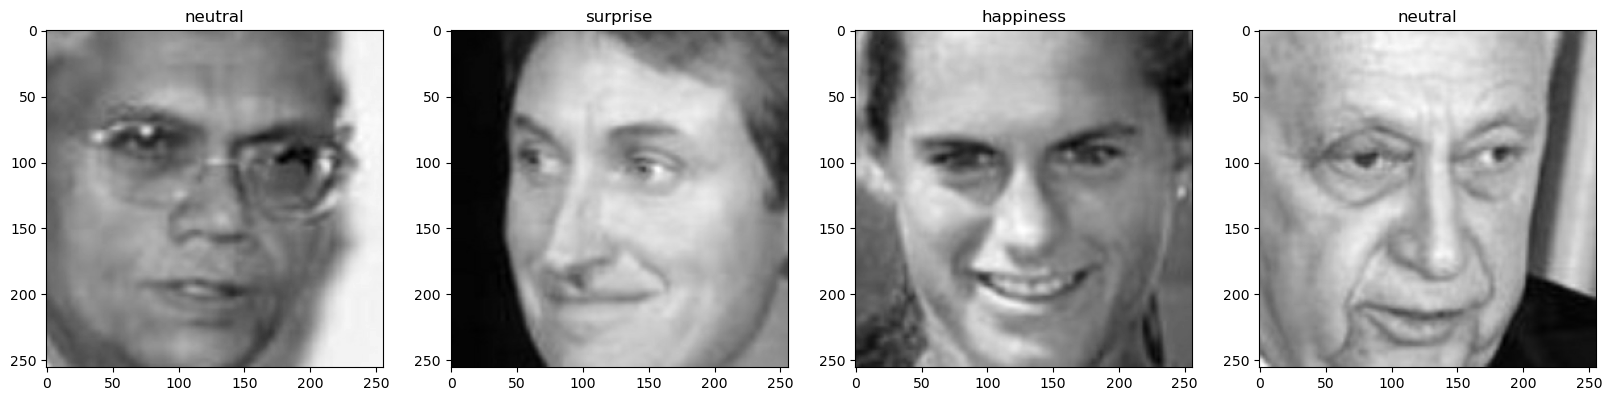

In [342]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img, cmap="gray")
    ax[idx].title.set_text(label_list[batch[1][idx]])

### Now our data is scaled, so now split data

In [343]:
len(img_data)

428

In [31]:
# how much data per partition
# aka how many batches in each
train_size = int(len(img_data)*.7) + 1
val_size = int(len(img_data)*.2) + 1
test_size = int(len(img_data)*.1)

# 300 +86 + 42

In [32]:
train = img_data.take(train_size)
val = img_data.skip(train_size).take(val_size)
test = img_data.skip(train_size+val_size).take(test_size)

In [25]:
for images, labels in train:
    print("Batch Labels Shape:", labels.shape)
    print("Batch Labels Example:", labels.numpy()[0])
    break  # Break after the first batch to inspect it

Batch Labels Shape: (32,)
Batch Labels Example: 5


### Making our model

In [33]:
model = Sequential()

In [34]:
model.add(Conv2D(64, (3,3), 1, activation='relu', input_shape=(256,256,1))) # convolutional layer
model.add(MaxPooling2D()) # condenses our info

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(8, activation='softmax'))

In [35]:
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
 # optimizer = adam
 # loss
 # metrics = what we want to track

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 64)      640       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 16)       

### Train

In [22]:
logdir = 'logs'

In [23]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [37]:
#hist = model.fit(train, epochs=1, validation_data=val, callbacks=[tensorboard_callback])

try:
    hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])
except Exception as e:
    print("Error during training:", e)
    import traceback
    traceback.print_exc()

Epoch 1/10
300/300 [==============================] - 254s 837ms/step - loss: 1.0564 - accuracy: 0.4865 - val_loss: 1.0423 - val_accuracy: 0.4186
Epoch 2/10
300/300 [==============================] - 247s 822ms/step - loss: 1.0171 - accuracy: 0.5084 - val_loss: 0.9836 - val_accuracy: 0.5312
Epoch 3/10
300/300 [==============================] - 241s 800ms/step - loss: 0.9955 - accuracy: 0.5214 - val_loss: 0.9846 - val_accuracy: 0.5323
Epoch 4/10
300/300 [==============================] - 252s 840ms/step - loss: 0.9728 - accuracy: 0.5402 - val_loss: 0.9604 - val_accuracy: 0.5494
Epoch 5/10
300/300 [==============================] - 253s 842ms/step - loss: 0.9358 - accuracy: 0.5644 - val_loss: 0.9591 - val_accuracy: 0.5712
Epoch 6/10
300/300 [==============================] - 249s 829ms/step - loss: 0.8747 - accuracy: 0.5996 - val_loss: 0.9918 - val_accuracy: 0.5516
Epoch 7/10
300/300 [==============================] - 270s 891ms/step - loss: 0.7865 - accuracy: 0.6466 - val_loss: 1.0213 -

In [251]:
for images, labels in img_data.take(2):  # Take the first batch
    input_shape = images.shape[1:]
    print("Input shape:", input_shape)

Input shape: (256, 256, 1)
Input shape: (256, 256, 1)


In [38]:
test_loss, test_acc = model.evaluate(test, verbose=2)

42/42 - 13s - loss: 2.0166 - accuracy: 0.5056 - 13s/epoch - 317ms/step


In [39]:
test_loss, test_acc = model.evaluate(val, verbose=2)

86/86 - 12s - loss: 1.8816 - accuracy: 0.5312 - 12s/epoch - 137ms/step


In [40]:
test_loss, test_acc = model.evaluate(train, verbose=2)

300/300 - 31s - loss: 0.4717 - accuracy: 0.8067 - 31s/epoch - 104ms/step


### CODE FROM OTHER VARIATIONS (UNTESTED) 

In [249]:
model=Sequential()

model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(256, 256, 1)))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation ="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))

model.add(Dense(2,activation="softmax"))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [245]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,1)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [254]:
model = Sequential()
# hidden layer
model.add(Dense(1, input_shape=(256,256,1), activation='relu'))
# output layer
model.add(Dense(1, activation='softmax'))
# looking at the model summary
model.summary()
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.fit(train, batch_size=128, epochs=10, validation_data=val)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 256, 256, 1)       2         
                                                                 
 dense_19 (Dense)            (None, 256, 256, 1)       2         
                                                                 
Total params: 4 (16.00 Byte)
Trainable params: 4 (16.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\tensorflow\python\util\dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 256, 256, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


ValueError: in user code:

    File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None,) and (None, 256, 256, 1) are incompatible


### Train

In [231]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20




UnimplementedError: Graph execution error:

Detected at node binary_crossentropy/Cast defined at (most recent call last):
  File "C:\Users\steie\miniconda3\envs\cs178\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Users\steie\miniconda3\envs\cs178\lib\runpy.py", line 86, in _run_code

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\traitlets\config\application.py", line 1046, in launch_instance

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\tornado\platform\asyncio.py", line 215, in start

  File "C:\Users\steie\miniconda3\envs\cs178\lib\asyncio\base_events.py", line 603, in run_forever

  File "C:\Users\steie\miniconda3\envs\cs178\lib\asyncio\base_events.py", line 1909, in _run_once

  File "C:\Users\steie\miniconda3\envs\cs178\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\steie\AppData\Local\Temp\ipykernel_22740\708507988.py", line 3, in <module>

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\engine\training.py", line 1151, in train_step

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\losses.py", line 270, in call

  File "C:\Users\steie\miniconda3\envs\cs178\lib\site-packages\keras\src\losses.py", line 2521, in binary_crossentropy

Cast string to float is not supported
	 [[{{node binary_crossentropy/Cast}}]] [Op:__inference_train_function_2162]

## Playing with sift

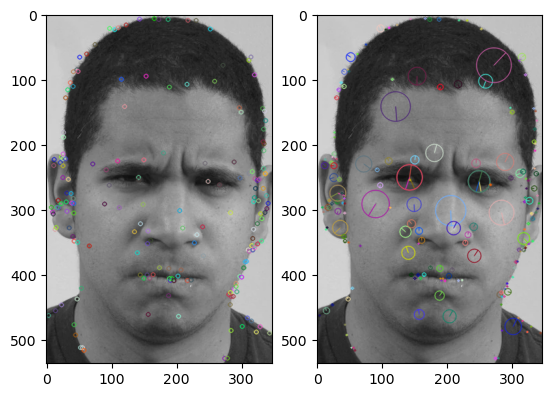

In [390]:
fig, ax =  plt.subplots(1, 2) # , figsize=(10,7))

#reading image
img = cv2.imread('../CS 178/cs178_facial_expressions/images/facial-expressions_2868588k.jpg')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#keypoints
sift = cv2.SIFT_create()
kp = sift.detect(gray,None)



img=cv2.drawKeypoints(gray,kp,img)# ,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) #flags: shows circle of size of kp and will show it's orientation
cv2.imwrite('sift_keypoints.jpg',img)
ax[0].imshow(img)

img=cv2.drawKeypoints(gray,kp,img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) #flags: shows circle of size of kp and will show it's orientation
cv2.imwrite('sift_keypoints.jpg',img)
ax[1].imshow(img)
# gives us data we can use des: numpy array of shape (num of kp) x 128
kp,des = sift.compute(gray,kp)

### Comparing Images w/ SIFT

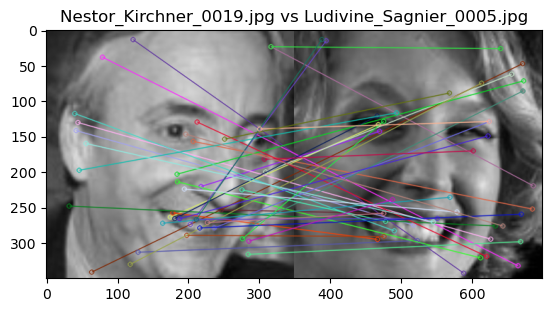

num of matches: 42
24.0


In [154]:
avg_matches = 0
total = 0
iter = 1

while True:
    sample = facial_df[facial_df['emotion']=="happiness"]['image'].sample(2).values
    
    img1 = "../CS 178/cs178_facial_expressions/images/" + str(sample[0])
    img2 = "../CS 178/cs178_facial_expressions/images/" + str(sample[1])
    
    #reading images
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)
    
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    #sift
    sift = cv2.SIFT_create() # creates a sift object
    
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
    
    
    #feature matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    
    matches = bf.match(descriptors_1,descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)

    if len(matches) > 40:
        img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
        plt.title(f"{sample[0]} vs {sample[1]}")
        plt.imshow(img3),plt.show()
        
        print("num of matches:", len(matches))
    
    total += len(matches)

    if iter == 50:
        avg_matches = total/iter
        break
    iter += 1
print(avg_matches)

# over 50
# test 1: avg = 21.94
# test 2: avg = 22.9
# test 3: avg = 24

(< cv2.KeyPoint 000001B3BB6CADF0>, < cv2.KeyPoint 000001B3D537D770>, < cv2.KeyPoint 000001B3D537D8C0>, < cv2.KeyPoint 000001B3D537D1A0>, < cv2.KeyPoint 000001B3D537DFE0>, < cv2.KeyPoint 000001B3D537D8F0>, < cv2.KeyPoint 000001B3D537D050>, < cv2.KeyPoint 000001B3D537F8A0>, < cv2.KeyPoint 000001B3D537D440>, < cv2.KeyPoint 000001B3D537DAA0>, < cv2.KeyPoint 000001B3D537E160>, < cv2.KeyPoint 000001B3D537DBF0>, < cv2.KeyPoint 000001B3D537DC20>, < cv2.KeyPoint 000001B3D537E220>, < cv2.KeyPoint 000001B3D537E010>, < cv2.KeyPoint 000001B3D537E040>, < cv2.KeyPoint 000001B3D537DEC0>, < cv2.KeyPoint 000001B3D537DEF0>, < cv2.KeyPoint 000001B3D537DF20>, < cv2.KeyPoint 000001B3D537DDA0>, < cv2.KeyPoint 000001B3D537DDD0>, < cv2.KeyPoint 000001B3D537DE00>, < cv2.KeyPoint 000001B3D537F0C0>, < cv2.KeyPoint 000001B3D537F0F0>, < cv2.KeyPoint 000001B3D537F120>, < cv2.KeyPoint 000001B3D537F150>, < cv2.KeyPoint 000001B3D537F180>, < cv2.KeyPoint 000001B3D537F1B0>, < cv2.KeyPoint 000001B3D537F1E0>, < cv2.KeyPoin

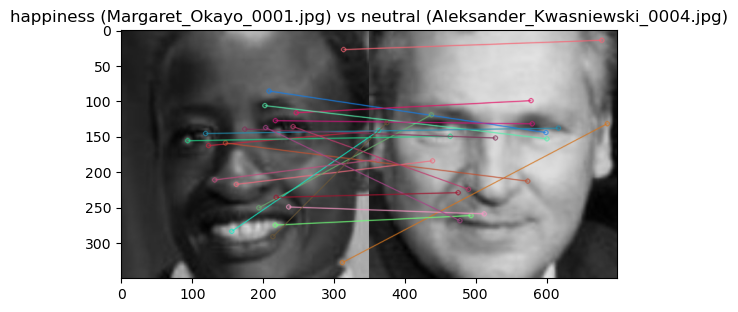

num of matches: 21


In [256]:
iter = 0
while True:
    iter += 1
    if iter == 2:
        break
        
    sample = facial_df[facial_df['emotion']=="happiness"]['image'].sample(1).values
    sample2 = facial_df[facial_df['emotion']=="neutral"]['image'].sample(1).values
    
    img1 = "../CS 178/cs178_facial_expressions/images/" + str(sample[0])
    img2 = "../CS 178/cs178_facial_expressions/images/" + str(sample2[0])
    
    #reading images
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)
    
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    #sift
    sift = cv2.SIFT_create() # creates a sift object
    
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
    
    print(keypoints_1, descriptors_1)
    print(keypoints_2, descriptors_2)
    #feature matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    
    matches = bf.match(descriptors_1,descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)
    print(matches)
    img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
    plt.title(f"happiness ({sample[0]}) vs neutral ({sample2[0]})")
    plt.imshow(img3),plt.show()
    
    print("num of matches:", len(matches))
    

# over 50
# test 1: avg = 21.94
# test 2: avg = 22.9
# test 3: avg = 24